<a href="https://colab.research.google.com/github/corycates8298/Prediction-Analyses-/blob/main/Item%20Sales%20Prediction%20Analysis%20July%202023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales
  - Author: Cory N. Cates
## Project Overview
## Load and Inspect Data


# Predictive Sales Analysis:

### This Analysis has been conducted to predict the Item Sales Values.  The Item Sales Prediction is designed to analyze and predict item sales from stores. This notebook utilizes various data science techniques and machine learning algorithms to gain insights into historical sales data and make accurate predictions for future sales.

**Variable Name & Description**
- **Item_Identifier**	- Product ID
- **Item_Weight	Weight** - of product
- **Item_Fat_Content**	- Whether the product is low-fat or regular
- **Item_Visibility**	- The percentage of total display area of all products in a   
  store allocated to the particular product
- **Item_Type**	- The category to which the product belongs
- **Item_MRP**	- Maximum Retail Price (list price) of the product
- **Outlet_Identifier**	Store ID
- **Outlet_Establishment_Year**	- The year in which store was established
- **Outlet_Size**	- The size of the store in terms of ground area covered
- **Outlet_Location_Type**	- The type of area in which the store is located
- **Outlet_Type**	- Whether the outlet is a grocery store or some sort of     supermarket
- **Item_Outlet_Sales	Sales** - of the product in the particular store. This is the
  target variable to be predicted.

Original Kaggle Data:  https://drive.google.com/file/d/1syH81TVrbBsdymLT_jl2JIf6IjPXtSQw/view?usp=sharing

# Evaluate using the built in Coding Snippets ******************START****************

In [237]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor # NEW
from sklearn.ensemble import BaggingRegressor # NEW
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [156]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
# Add **kwargs as keyword when defining function
# Include **kwargs in the sns.regplot() within the function

def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales', figsize=(6,4), **kwargs): # kwargs for sns.regplot
  # Calculate the correlation
  corr = df_predict[[x,y]].corr(numeric_only=True).round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

In [158]:
def plot_categorical_vs_target(df, x, y='SalePrice',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax



In [159]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

In [160]:
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



******************END OF SNIPPET****************

In [161]:
# Save path of file and inspect data

fpath= ('/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week05/Data/sales_predictions_2023 (1).csv')

df_predict = pd.read_csv(fpath)
df_predict.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [162]:
# Further data analysis
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- There are 8523 Rows with 12 columns

## Clean Data

In [163]:
# Getting shape of df
df_predict.shape

(8523, 12)

In [164]:
# Checking the variable data types

df_predict.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

- There are zero Unamed columns.
- Nothing that stands out in regards to the datatypes.

In [165]:
# Checking for duplicates

df_predict.duplicated().sum()

0

In [166]:
# Checking for Missing values
df_predict.isna()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,False,False,False,False,False,False,False,False,False,False,False,False
8519,False,False,False,False,False,False,False,False,True,False,False,False
8520,False,False,False,False,False,False,False,False,False,False,False,False
8521,False,False,False,False,False,False,False,False,False,False,False,False


In [167]:
# Checking for Missing values

df_sum = df_predict.isna().sum()
df_sum

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- There are 1463 rows that are missing for Item_Weight and 2410 for Outlet_type

In [168]:
# Identify the percentage missing
df_perc = df_predict.isna().sum() / len(df_predict) * 100
df_perc.round(2)

Item_Identifier               0.00
Item_Weight                  17.17
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.28
Outlet_Location_Type          0.00
Outlet_Type                   0.00
Item_Outlet_Sales             0.00
dtype: float64

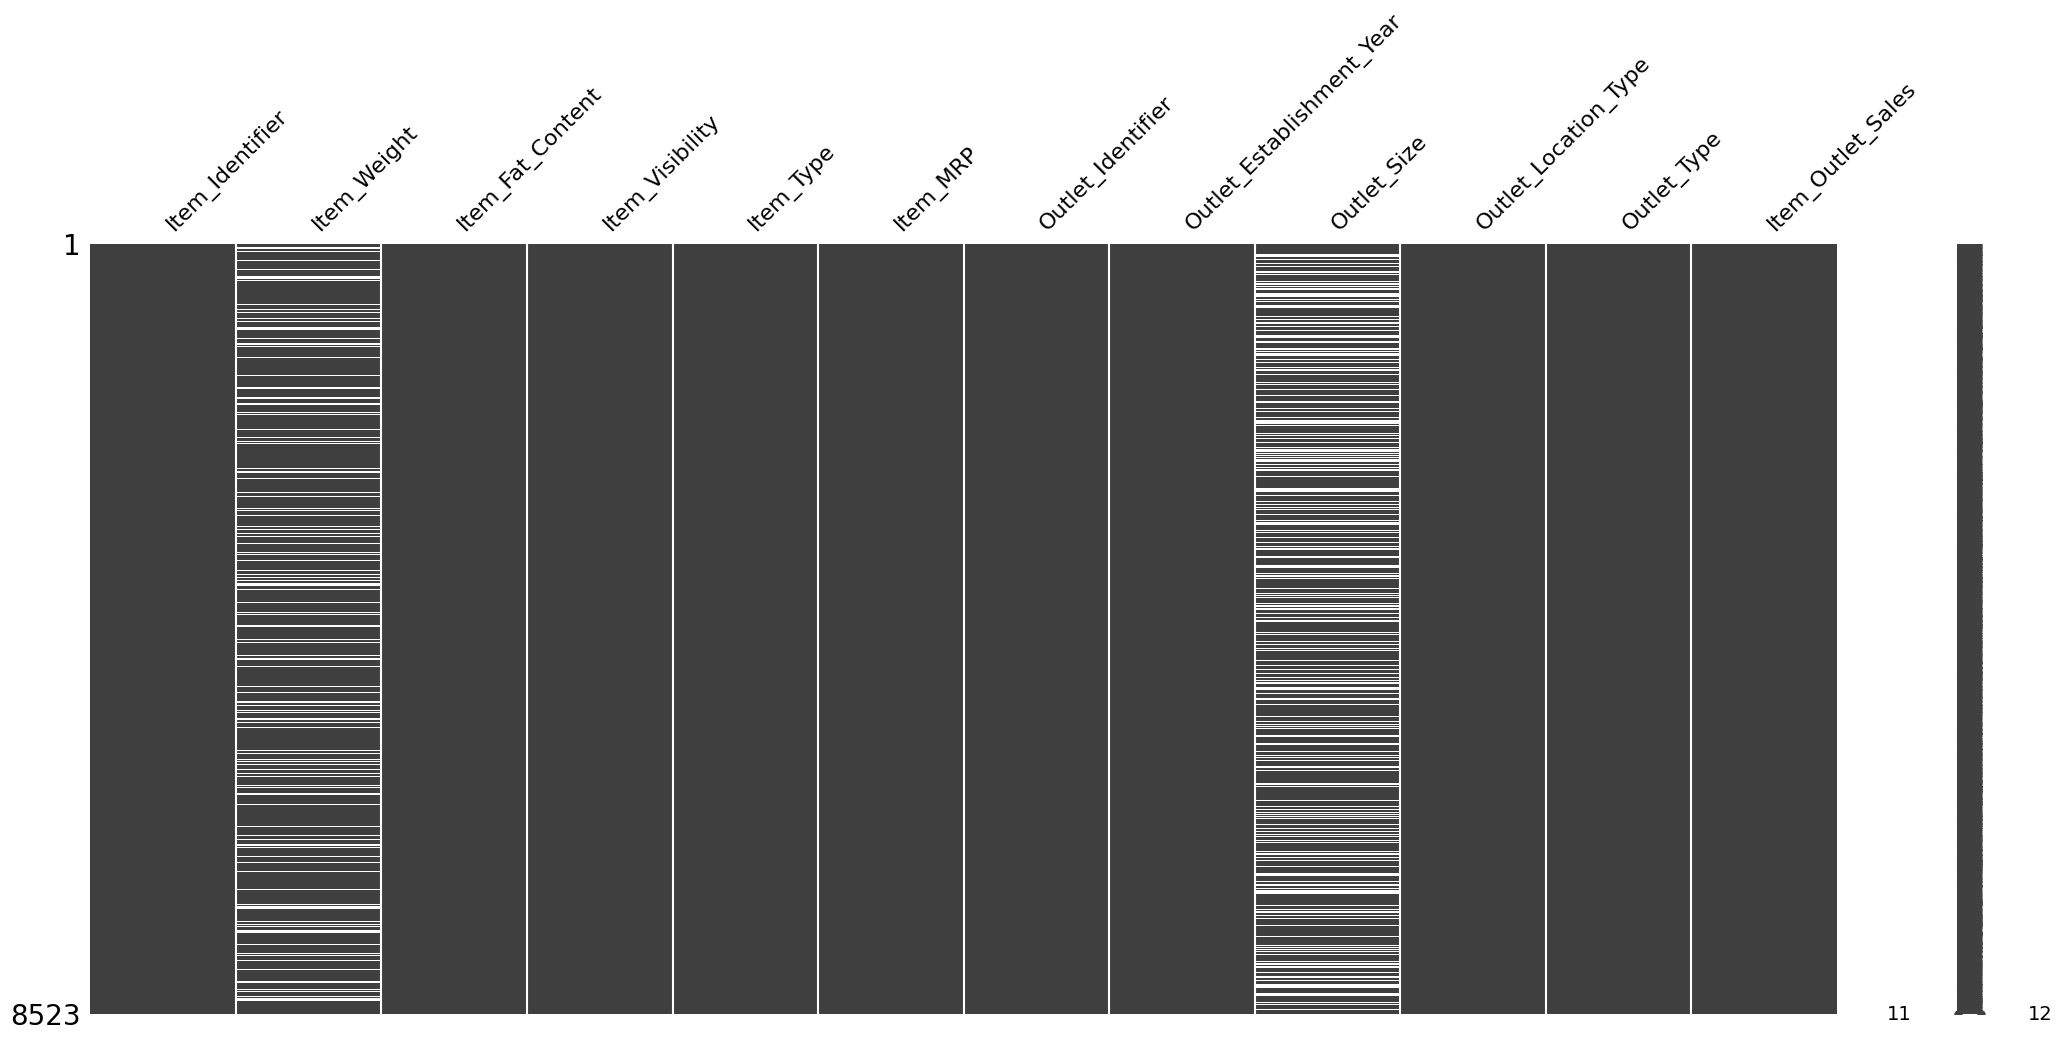

In [169]:
#Visualizing Null values with missingno; importing libraries as well
import missingno as msno
msno.matrix(df_predict);

- Addressing missing values

In [170]:
# Displaying number columns
num_cols = df_predict.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [171]:
# Displaying object cols
cat_cols = df_predict.select_dtypes('object').columns
cat_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [172]:
# Identify string columns to look for discrepancies
string_cols = df_predict.select_dtypes("object").columns
string_cols
# Obtain the value counts for all string columns
for col in string_cols:
  print(f"Value Counts for {col}")
  print(df_predict[col].value_counts())
  # Increasing readability by adding an empty line
  print('\n')


Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


In [173]:
# Fixing discrepancies that are shown in Item_Fat_Content
df_predict['Item_Fat_Content'] = df_predict['Item_Fat_Content'].replace('reg', 'Regular')
df_predict['Item_Fat_Content'] = df_predict['Item_Fat_Content'].replace('low fat', 'Low Fat')
df_predict['Item_Fat_Content'] = df_predict['Item_Fat_Content'].replace('LF', 'Low Fat')
df_predict['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [174]:
# Statistical analysis of the dataframe (Max, Min, Mean)
df_predict.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


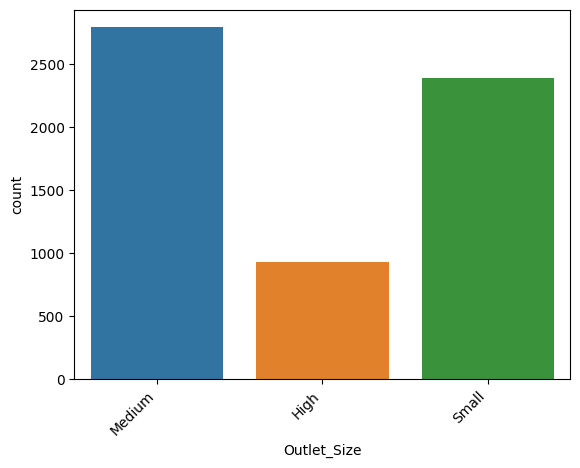

In [175]:
# Evaluating the Outlet Size column's counts

ax = sns.countplot(data = df_predict, x = 'Outlet_Size')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

- Medium and Small more prevalent than High

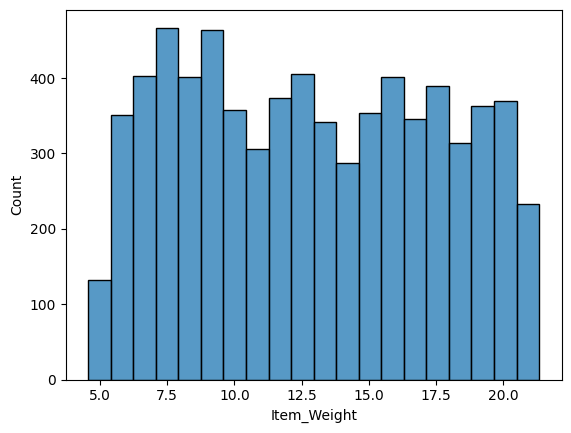

In [176]:
# Distribution of Item Weight
ax = sns.histplot(data = df_predict, x = 'Item_Weight')

-  Doesn't necessarily follow the normal bell curve that could easily distinguish the mean.  Fairly evenly distributed throughout.  

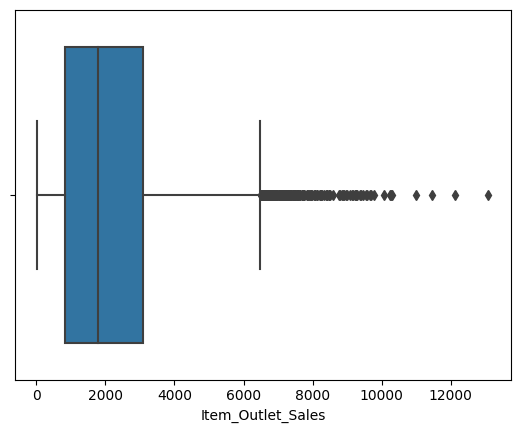

In [177]:
# Create a boxplot of for Outlet Sales
ax = sns.boxplot(data=df_predict, x= 'Item_Outlet_Sales')

- Median sales close to 2000.  There are tons of outliers that seem to be hard to determine from this view.

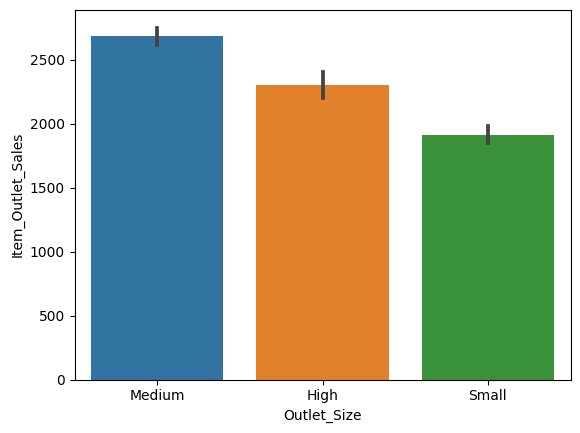

In [178]:
# Plotting Item Sales vs Outlet Size
ax = sns.barplot(data = df_predict, y = 'Item_Outlet_Sales', x ='Outlet_Size')

- Medium seems to be outperforming the lot

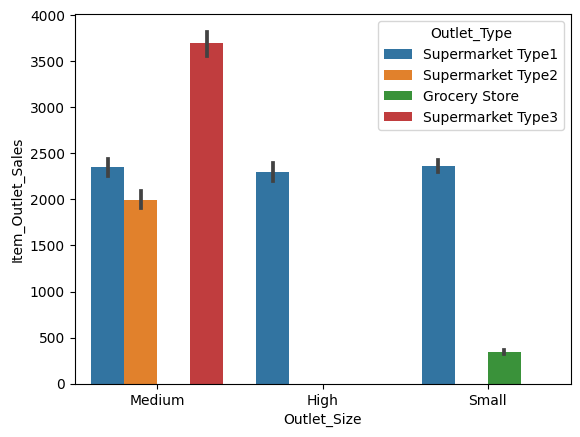

In [179]:
# Plotting Item Sales vs Outlet Size
ax = sns.barplot(data = df_predict, y = 'Item_Outlet_Sales', x ='Outlet_Size', hue='Outlet_Type')

# Further breaking this down by Type of store

In [180]:
# Defining variable for heatmap....Adding annotation to see the values
corr = df_predict.corr(numeric_only = True)
corr.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.03,-0.01,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.03,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,-0.01,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,0.01,-0.13,0.57,-0.05,1.00


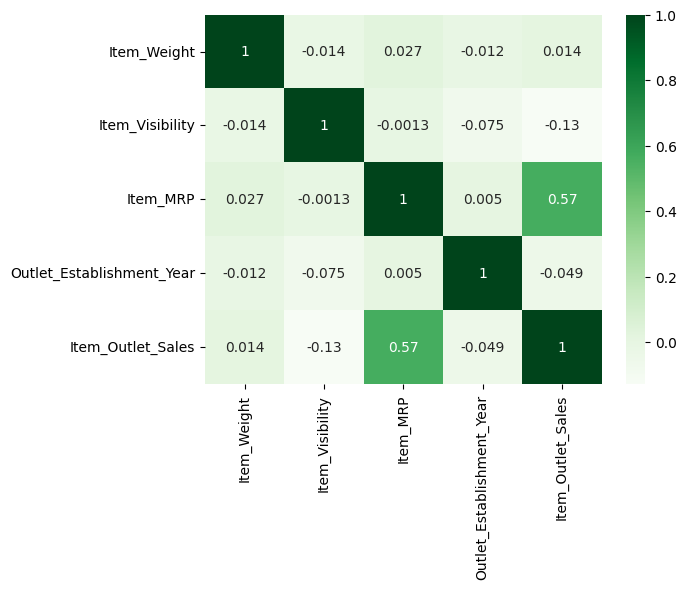

In [181]:
# Adding annotation to see the values
sns.heatmap(corr, cmap = 'Greens', annot = True);

- It is a correlation between item_mrp an item_outlet_sales, however not that strong.   Looks to be at 0.57, with 1 being the strongest.

## Exploratory Data Analysis

### Objects: Item_Identifier, Item_Fat_Content, , Item_Type, Item_Fat_Content, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, Outlet_Type

### Numeric Values: Item_Weight, Item_Visibility, Item_MRP Outlet_Establishment_Year', 'Item_Outlet_Sales
      


- Inspecting Categorical

In [182]:
feature_one = "Item_Identifier"
feature_two = "Item_Fat_Content"
feature_three = "Item_Type"
feature_four = "Outlet_Identifier"
feature_five = "Outlet_Size"
feature_six = "Outlet_Location_Type"
feature_seven = "Outlet_Type"
feature_eight = "Item_Weight"
feature_nine = "Item_Visibility"
feature_ten = "Item_MRP"
feature_ele = "Outlet_Establishment_Year"
feature_twel = "Item_Outlet_Sales"


## Explanatory Data Analysis

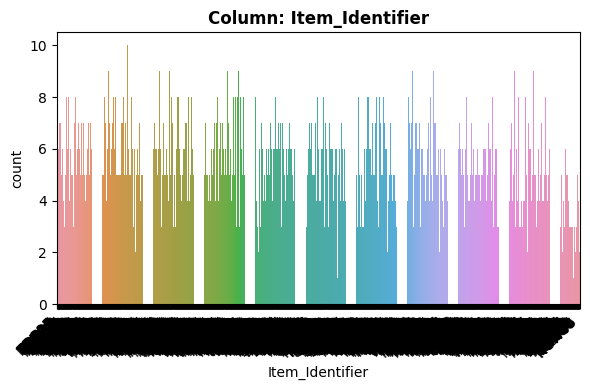

- NaN's Found: 0 (0.0%)
- Unique Values: 1559
- Most common value: 'FDW13' occurs 10 times (0.12%)
- Not constant or quasi-constant.


In [183]:
# Calling our custom EDA function
explore_categorical(df_predict, feature_one, placeholder='NaN');

 - What type of feature is it? (Categorical (nominal), ordinal, numeric):  CATEGORICAL
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) : ZERO NULLs
  - Is the feature constant or quasi-constant?  :  NO, most common shows .12%
  - What is the cardinality? Is it high (>10)?  : 1559, Yes
  - Would we know this feature before the target is determined? :  Yes
  - Is there a business case/understanding reason to exclude based on our business case? :  Yes, this is just an identifier.  Most likely used in stores to lump products together.  

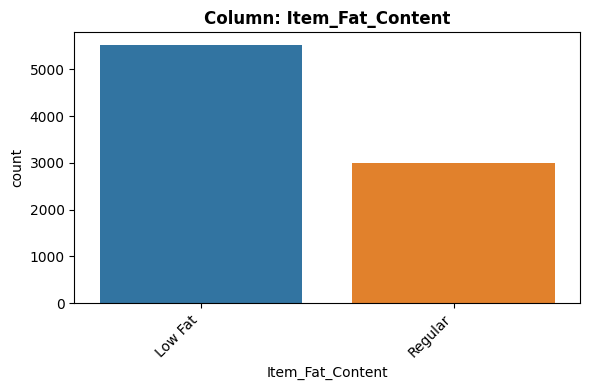

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [184]:
# Calling our custom EDA function
explore_categorical(df_predict, feature_two, placeholder='NaN');

 - What type of feature is it? (Categorical (nominal), ordinal, numeric):  CATEGORICAL
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) : ZERO NULLs
  - Is the feature constant or quasi-constant?  :  NO, most common shows .12%
  - What is the cardinality? Is it high (>10)?  : 2, No
  - Would we know this feature before the target is determined? :  Yes
  - Is there a business case/understanding reason to exclude based on our business case? :  Possibly,  Maybe the store is a store that promotes diet food.  This could determine sales.  

- Multivariate Viz

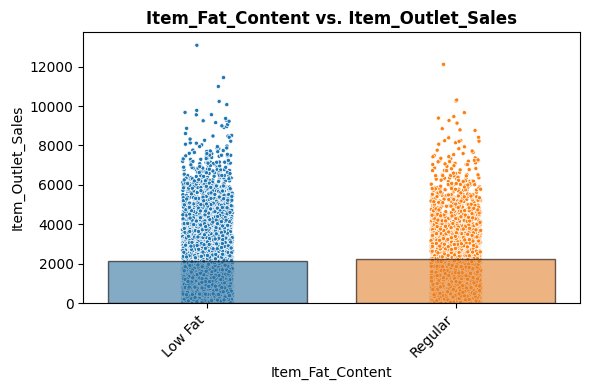

In [185]:
# Calling our custom EDA function
plot_categorical_vs_target(df_predict, feature_two, feature_twel);

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I would expect that fat content would be somewhat of a driver for sales.
- Does this feature appear to be a predictor of the target?
  - No, it appears to be pretty even across the board.

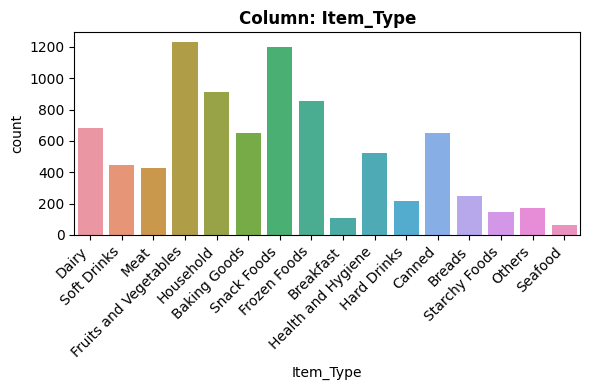

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [186]:
# Calling our custom EDA function
explore_categorical(df_predict, feature_three, placeholder='NaN');

 - What type of feature is it? (Categorical (nominal), ordinal, numeric):  CATEGORICAL
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) : ZERO NULLs
  - Is the feature constant or quasi-constant?  :  NO, most common shows 14%
  - What is the cardinality? Is it high (>10)?  : 16, Yes
  - Would we know this feature before the target is determined? :  Yes
  - Is there a business case/understanding reason to exclude based on our business case? :  No, the type of Item definitly plays a role in the about of sales.  

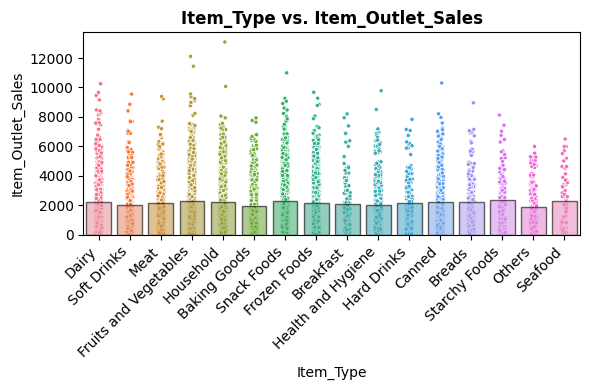

In [187]:
# Calling our custom EDA function
plot_categorical_vs_target(df_predict, feature_three, feature_twel);

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I would expect that the type of item would be a factor in sales.
- Does this feature appear to be a predictor of the target?
  - No, again....it appears to be pretty even across the board.  There are some outliers in Veges and Household goods...but there is no clear distinction.  

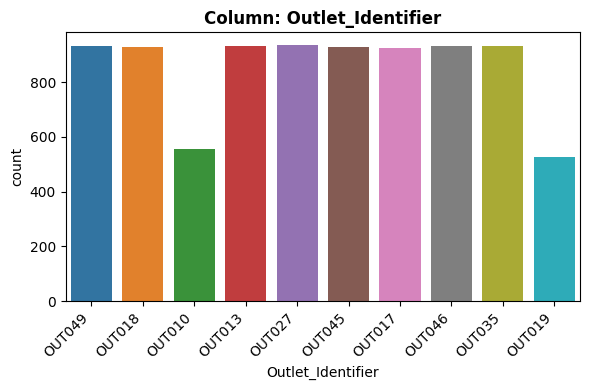

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


In [188]:
# Calling our custom EDA function
explore_categorical(df_predict, feature_four, placeholder='NaN');

 - What type of feature is it? (Categorical (nominal), ordinal, numeric):  CATEGORICAL
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) : ZERO NULLs
  - Is the feature constant or quasi-constant?  :  NO, most common shows .12%
  - What is the cardinality? Is it high (>10)?  : 10, No...equal to 10
  - Would we know this feature before the target is determined? :  Yes
  - Is there a business case/understanding reason to exclude based on our business case? :  Yes, this is just an identifier for stores.  

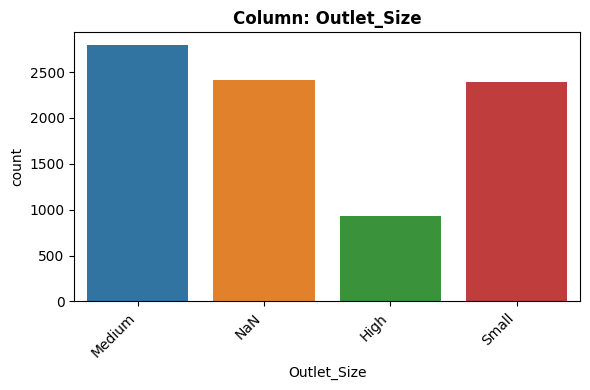

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


In [189]:
# Calling our custom EDA function
explore_categorical(df_predict, feature_five, placeholder='NaN');

 - What type of feature is it? (Categorical (nominal), ordinal, numeric):  Ordinal
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) : 2410 NULLs making up 28.28%.  I would impute to MISSING.  The data dictionary doesn't imply that this should change or is super important.  
  - Is the feature constant or quasi-constant?  :  NO, most common shows 28%
  - What is the cardinality? Is it high (>10)?  : 4, No
  - Would we know this feature before the target is determined? :  Yes
  - Is there a business case/understanding reason to exclude based on our business case? : Possibly, some customers like larger stores when shopping and some like smaller (more customer friendly in some cases...people tend to know locals).

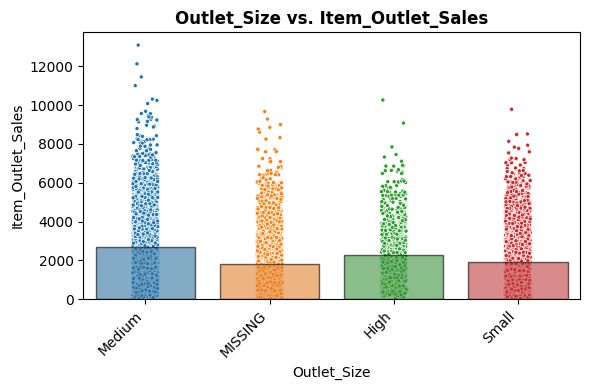

In [190]:
# Calling our custom EDA function
plot_categorical_vs_target(df_predict, feature_five, feature_twel);

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I would expect that the outlet size would be a driver for sales.
- Does this feature appear to be a predictor of the target?
  - Not 100 percent clear, but, it appears that the medium size store has a bit of an edge on the others; however, we don't know what the missing values are and what category they belong to.  That could determine a lot.

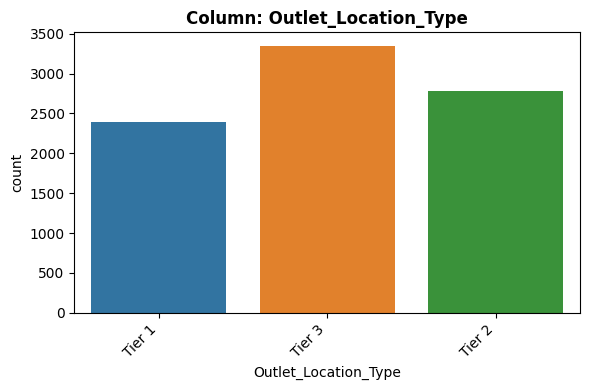

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


In [191]:
# Calling our custom EDA function
explore_categorical(df_predict, feature_six, placeholder='NaN');

 - What type of feature is it? (Categorical (nominal), ordinal, numeric):  Ordinal
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) : ZERO NULLs
  - Is the feature constant or quasi-constant?  :  NO, most common shows 39%
  - What is the cardinality? Is it high (>10)?  : 3, No
  - Would we know this feature before the target is determined? :  Yes
  - Is there a business case/understanding reason to exclude based on our business case? :  No, The location type would defintely play a big factor in sales.  

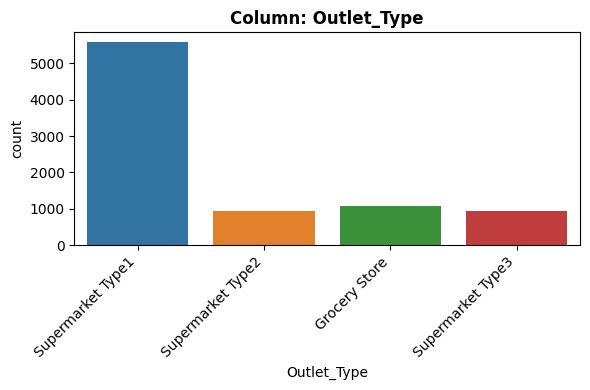

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


In [192]:
# Calling our custom EDA function
explore_categorical(df_predict, feature_seven, placeholder='NaN');

 - What type of feature is it? (Categorical (nominal), ordinal, numeric):  CATEGORICAL
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) : ZERO NULLs
  - Is the feature constant or quasi-constant?  :  NO, most common shows 65%
  - What is the cardinality? Is it high (>10)?  : 4, no
  - Would we know this feature before the target is determined? :  Yes
  - Is there a business case/understanding reason to exclude based on our business case? :  No, the type of market would play a factor in sales as well.  

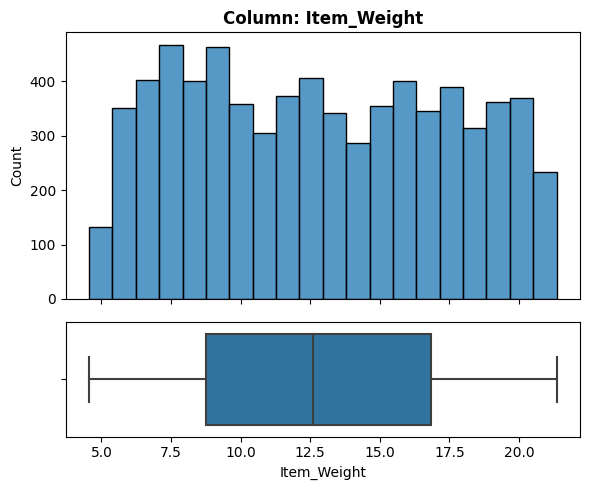

- NaN's Found: 1463 (17.17%)


In [193]:
# Calling our custom EDA function
explore_numeric(df_predict, feature_eight);

 - What type of feature is it? (Categorical (nominal), ordinal, numeric) :  NUMERIC
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) :  1463 NULL at a percentage of 17%

  - They seem to be missing a random.  Could be related to shrinkage.  

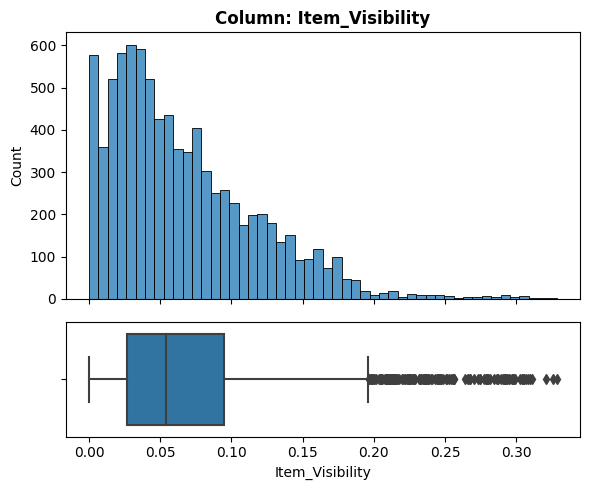

- NaN's Found: 0 (0.0%)


In [194]:
# Calling our custom EDA function
explore_numeric(df_predict, feature_nine);

 - What type of feature is it? (Categorical (nominal), ordinal, numeric) :  NUMERIC
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) :  ZERO NULL

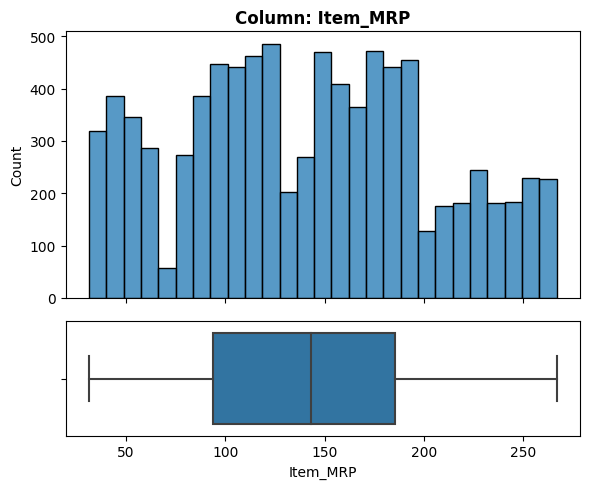

- NaN's Found: 0 (0.0%)


In [195]:
# Calling our custom EDA function
explore_numeric(df_predict, feature_ten);

 - What type of feature is it? (Categorical (nominal), ordinal, numeric) :  NUMERIC
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) :  ZERO NULL

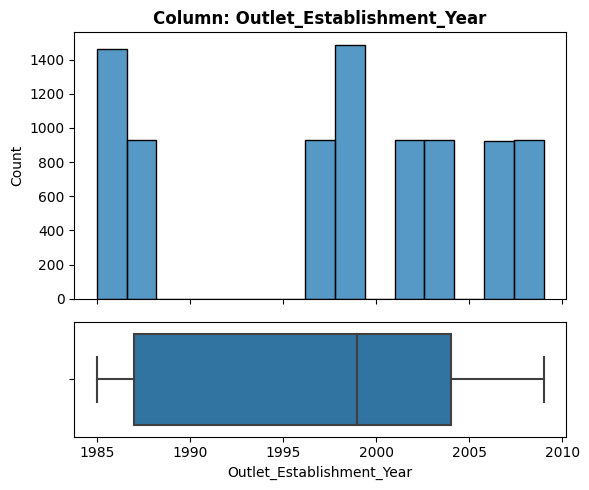

- NaN's Found: 0 (0.0%)


In [196]:
# Calling our custom EDA function
explore_numeric(df_predict, feature_ele);

 - What type of feature is it? (Categorical (nominal), ordinal, numeric) :  NUMERIC
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) :  ZERO NULL

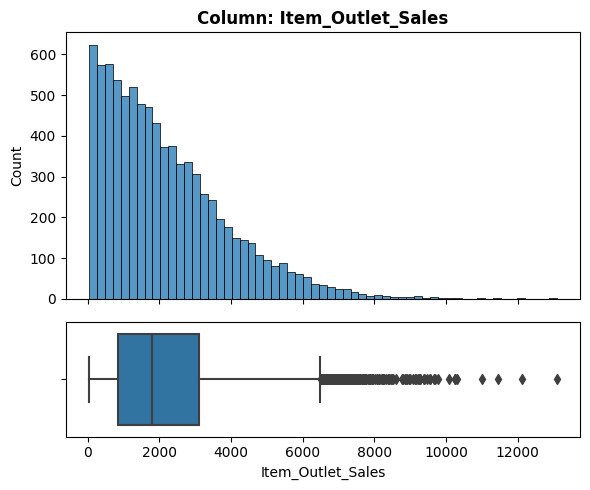

- NaN's Found: 0 (0.0%)


In [197]:
# Calling our custom EDA function
explore_numeric(df_predict, feature_twel);

 - What type of feature is it? (Categorical (nominal), ordinal, numeric) :  NUMERIC
  - How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?) :  ZERO NULL
  
  This is my target

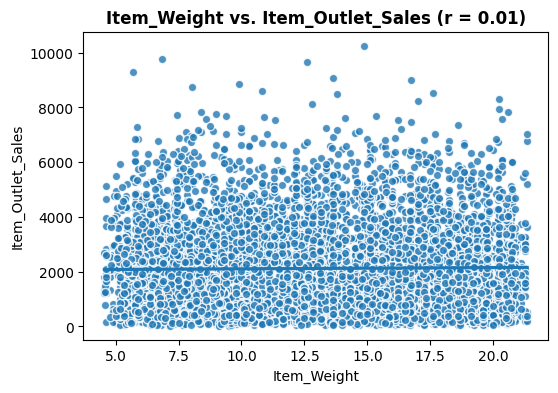

In [198]:
# Calling our custom EDA function
plot_numeric_vs_target(df_predict, feature_eight);


- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - No, I would not expect that the Item Weight would be a driver for sales.
- Does this feature appear to be a predictor of the target?
  - No or neutral correlation.  As X increases, Y stays the same.  

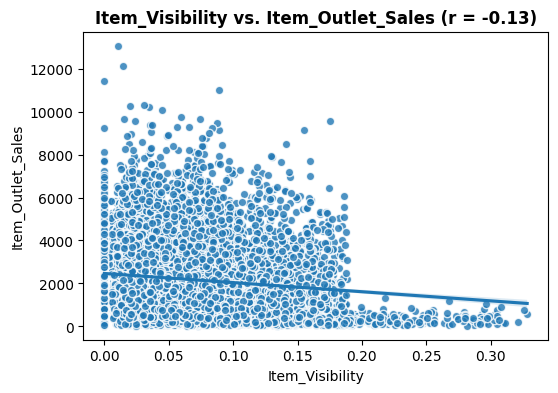

In [199]:
# Calling our custom EDA function
plot_numeric_vs_target(df_predict, feature_nine);

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - No, I would not expect that the Item Visibility would be a driver for sales.
- Does this feature appear to be a predictor of the target?
  - Negative correlation.  As X increases, Y decreases.  

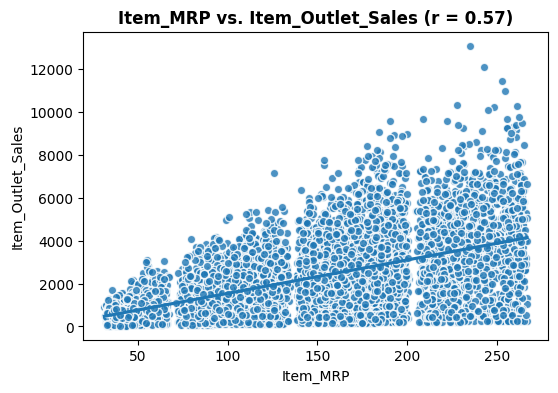

In [200]:
# Calling our custom EDA function
plot_numeric_vs_target(df_predict, feature_ten);

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - Yes, I would expect that the Item MRP would be a driver for sales.
- Does this feature appear to be a predictor of the target?
  - This is a pretty positive correlation with r at 0.57.  X increases and so does Y.  Which makes sense, it's the actual list price.  Actual price includes markup for profit.  

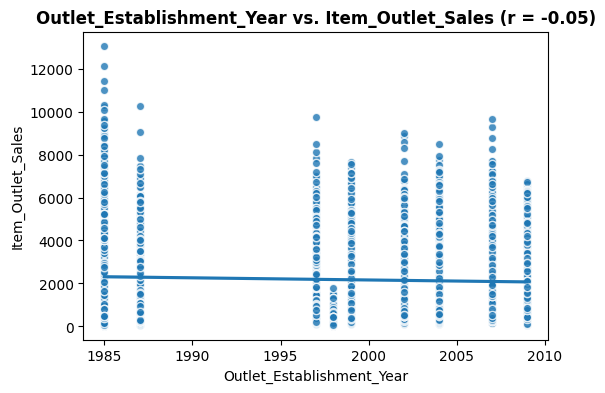

In [201]:
# Calling our custom EDA function
plot_numeric_vs_target(df_predict, feature_ele);

- Based on your business understanding, would you expect this feature to be a predictor of the target?
  - I think that it's possible, because customer base could change (+/-) throughout the years.  
- Does this feature appear to be a predictor of the target?
  - No, it has a negative r and Y(sales) decrease as the years change.  


Inconsistencies and Duplicates have been dropped.

In [202]:
# Separate features vs target & train/test split
drop_from_model = ['Item_Fat_Content', 'Item_Identifier','Outlet_Identifier','Item_Weight',
                   'Item_Visibility','Outlet_Establishment_Year']
# Demonstrating unpacking list with star operator
[*drop_from_model,'Item_Outlet_Sales']


['Item_Fat_Content',
 'Item_Identifier',
 'Outlet_Identifier',
 'Item_Weight',
 'Item_Visibility',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [203]:
# Separate features vs target & train/test split
drop_from_model = ['Item_Fat_Content', # Stakeholder can't change
                   'Item_Identifier', # Stakeholder can't change
                   'Outlet_Identifier', # Stakeholder can't change
                   'Item_Weight',  # Stakeholder can't change
                   'Item_Visibility',  # Had a negative correlation to sales
                   'Outlet_Establishment_Year'] # Stakeholder can't change
X = df_predict.drop(columns = [*drop_from_model,'Item_Outlet_Sales'])
y = df_predict['Item_Outlet_Sales']
# Import the TTS from sklearn
from sklearn.model_selection import train_test_split
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()


,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,Household,256.4646,Medium,Tier 3,Supermarket Type2
7510,Snack Foods,179.7660,Medium,Tier 3,Supermarket Type2
5828,Meat,157.2946,Medium,Tier 1,Supermarket Type1
5327,Baking Goods,82.3250,Small,Tier 2,Supermarket Type1
4810,Frozen Foods,120.9098,NaN,Tier 2,Supermarket Type1


In [204]:
# Showing X_train and y_train have the same PID's
display(X_train.head(3), y_train.head(3))

,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,Household,256.4646,Medium,Tier 3,Supermarket Type2
7510,Snack Foods,179.7660,Medium,Tier 3,Supermarket Type2
5828,Meat,157.2946,Medium,Tier 1,Supermarket Type1


4776     515.3292
7510    3056.0220
5828    1577.9460
Name: Item_Outlet_Sales, dtype: float64

### Numerical

In [205]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe



Numeric Columns: Index(['Item_MRP'], dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [206]:
# Making a ohe_tuple for ColumnTransformer
num_tuple = ('numerical', num_pipe, num_cols)
num_tuple


('numerical',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_MRP'], dtype='object'))

### Nominal

In [207]:
# Get the list of categorical and ordinal column names
cat_cols = X_train.select_dtypes("object").columns
print("OneHotEncoder Columns:", cat_cols)

# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: Index(['Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [208]:
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, cat_cols)
ohe_tuple



('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))

In [209]:
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
col_transformer


ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_MRP'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

In [210]:
# fit the col_transformer
X_train_transformed = col_transformer.fit_transform(X_train)
X_test_transformed = col_transformer.transform(X_test)
print(X_train_transformed.shape)
print(X_test_transformed.shape)
X_train_transformed.head()

(6392, 28)
(2131, 28)


,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_NA,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,1.828109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.603369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,0.244541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-0.952591,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,-0.336460,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Linear regression model to predict sales.



In [211]:
from sklearn.linear_model import LinearRegression
# Instantiate model
lin_reg = LinearRegression()
#Fit model
lin_reg.fit(X_train_transformed, y_train)

LinearRegression()

In [212]:
# View the intercept determined during the fit step
lin_reg.intercept_.round(2)


2088.57

In [213]:
# View the coefficents determined during the fit step
lin_reg.coef_.round(2)


array([  984.02,    -8.11,   -44.83,    41.52,    18.28,  -123.38,
          -9.21,    34.45,   -26.47,    -7.07,   -33.3 ,    -9.62,
         -65.19,   308.84,   -34.21,   -68.19,    26.48,    -1.79,
         114.98,  -117.31,     4.13,   -79.82,    65.81,    14.01,
       -1621.78,   273.26,  -179.99,  1528.5 ])

In [214]:
# Get a list of the feature names after processing
feature_names = col_transformer.get_feature_names_out()
feature_names


array(['Item_MRP', 'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_NA',
       'Outlet_Size_Small', 'Outlet_Location_Type_Tier 1',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

In [215]:
# Create a Pandas Series with feature name and coefficient
coeffs = pd.Series(lin_reg.coef_.round(2), index = feature_names)
coeffs


Item_MRP                            984.02
Item_Type_Baking Goods               -8.11
Item_Type_Breads                    -44.83
Item_Type_Breakfast                  41.52
Item_Type_Canned                     18.28
Item_Type_Dairy                    -123.38
Item_Type_Frozen Foods               -9.21
Item_Type_Fruits and Vegetables      34.45
Item_Type_Hard Drinks               -26.47
Item_Type_Health and Hygiene         -7.07
Item_Type_Household                 -33.30
Item_Type_Meat                       -9.62
Item_Type_Others                    -65.19
Item_Type_Seafood                   308.84
Item_Type_Snack Foods               -34.21
Item_Type_Soft Drinks               -68.19
Item_Type_Starchy Foods              26.48
Outlet_Size_High                     -1.79
Outlet_Size_Medium                  114.98
Outlet_Size_NA                     -117.31
Outlet_Size_Small                     4.13
Outlet_Location_Type_Tier 1         -79.82
Outlet_Location_Type_Tier 2          65.81
Outlet_Loca

In [216]:
# View the first row of features in the test set
X_test_transformed.head(1)


,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_NA,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,-0.998816,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [217]:
#Get predictions for training and test data
y_pred_train = lin_reg.predict(X_train_transformed)
y_pred_test = lin_reg.predict(X_test_transformed)

In [218]:
# Saving a copy of X_test_transformed and adding the true and predicted price and the error
prediction_df = X_test_transformed.copy()
prediction_df['True Sales'] = y_test
prediction_df['Predicted Sales'] = y_pred_test.round(1)
prediction_df['Error'] = (y_pred_test - y_test).round(1)
prediction_df.head(10)

,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_NA,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,True Sales,Predicted Sales,Error
7503,-0.998816,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1743.0644,1382.0,-361.1
2957,-1.585194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,356.8688,719.2,362.3
7031,-1.595784,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,377.5086,845.0,467.5
1084,0.506592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5778.4782,4176.4,-1602.1
856,0.886725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2356.9320,3294.7,937.8
4304,-1.748367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,865.5400,608.4,-257.2
2132,1.070615,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4613.9940,4817.8,203.8
1385,0.000559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2410.8618,2003.9,-407.0
5239,-0.620321,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1948.1308,1419.0,-529.1
6516,0.801084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1937.4780,2792.5,855.1


In [219]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics


In [220]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)


In [221]:
# Test function using test data and default for output_dict
regression_metrics(y_test, y_pred_test, label = 'Test Data')


------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.598
- MSE = 1,195,213.183
- RMSE = 1,093.258
- R^2 = 0.567


In [222]:
# Test function on training data and save the dictionary as a variable
training_metrics = regression_metrics(y_train, y_pred_train, label = 'Training Data', output_dict = True)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.355
- MSE = 1,299,873.757
- RMSE = 1,140.120
- R^2 = 0.561


In [223]:
# Confirm dictionary
training_metrics


{'Label': 'Training Data',
 'MAE': 847.3552118770169,
 'MSE': 1299873.7572635945,
 'RMSE': 1140.1200626528746,
 'R^2': 0.5607726936830288}

In [224]:
 # Test function with default arguments
evaluate_regression(lin_reg, X_train_transformed, y_train, X_test_transformed, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.355
- MSE = 1,299,873.757
- RMSE = 1,140.120
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.598
- MSE = 1,195,213.183
- RMSE = 1,093.258
- R^2 = 0.567


In [247]:
from operator import length_hint
# Test function by saving results as a datframe
len_reg = evaluate_regression(lin_reg, X_train_transformed, y_train, X_test_transformed, y_test,
                              output_frame=True)
len_reg


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.355
- MSE = 1,299,873.757
- RMSE = 1,140.120
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.598
- MSE = 1,195,213.183
- RMSE = 1,093.258
- R^2 = 0.567


,MAE,MSE,RMSE,R^2
Training Data,847.355,1299873.757,1140.120,0.561
Test Data,804.598,1195213.183,1093.258,0.567


In [226]:
# Test function by saving results as a dataframe and suppressing print statements with verbose = False
results = evaluate_regression(lin_reg, X_train_transformed, y_train, X_test_transformed, y_test, verbose = False, output_frame = True)
# View the dataframe
results

,MAE,MSE,RMSE,R^2
Training Data,847.355,1299873.757,1140.120,0.561
Test Data,804.598,1195213.183,1093.258,0.567


### Utilized the Tree Regressor model

In [240]:
# Instantiate a Default Model
bagreg = BaggingRegressor(random_state = 42)
# Model Pipeline with default preprocessor and default model
bagreg_pipe = make_pipeline(col_transformer, bagreg)
# Fit the model pipeline on the training data only
bagreg_pipe.fit(X_train, y_train)
# Call custom function for evaluation
evaluate_regression(bagreg_pipe, X_train, y_train, X_test, y_test)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 329.091
- MSE = 256,305.653
- RMSE = 506.266
- R^2 = 0.913

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 828.880
- MSE = 1,432,412.454
- RMSE = 1,196.834
- R^2 = 0.481


In [241]:
# Obtain list of parameters for Tuning
bagreg_pipe.get_params()


{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numerical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_MRP'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='NA',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   

In [242]:
# Define parameters to tune
param_grid = {'baggingregressor__n_estimators': [5, 10, 20, 30, 40, 50],
              'baggingregressor__max_samples' : [.5, .7, .9, ],
              'baggingregressor__max_features': [.5, .7, .9 ]}
# Instaniate the gridsearch
gridsearch = GridSearchCV(bagreg_pipe, param_grid, n_jobs=-1, verbose=1)
# Fit the gridsearch on the training data
gridsearch.fit(X_train, y_train)
# Obtain the best paramters from the gridsearch
gridsearch.best_params_


Fitting 5 folds for each of 54 candidates, totalling 270 fits


{'baggingregressor__max_features': 0.9,
 'baggingregressor__max_samples': 0.5,
 'baggingregressor__n_estimators': 50}

In [248]:
# Define a model with the best parameters already refit on the entire training set
best_bagreg_grid = gridsearch.best_estimator_
# Evalute the tuned model
bag_tune = evaluate_regression(best_bagreg_grid, X_train, y_train, X_test, y_test)

bag_tune


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 506.993
- MSE = 531,614.018
- RMSE = 729.119
- R^2 = 0.820

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 774.616
- MSE = 1,251,857.531
- RMSE = 1,118.864
- R^2 = 0.546


## The Len Regression is and example of underfitting.  The Test and Train Data are fairly low, and they are almost identical.  The Tree Regression, in both the Tuned/Non Tuned are depicting Overfitting.  Train data is much larger than the test.

## ***Len Regression***

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.355
- MSE = 1,299,873.757
- RMSE = 1,140.120
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.598
- MSE = 1,195,213.183
- RMSE = 1,093.258
- R^2 = 0.567

## ***Tree Regressor***

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 329.091
- MSE = 256,305.653
- RMSE = 506.266
- R^2 = 0.913

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 828.880
- MSE = 1,432,412.454
- RMSE = 1,196.834
- R^2 = 0.481
## ***Tree Regressor Tuned***
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 506.993
- MSE = 531,614.018
- RMSE = 729.119
- R^2 = 0.820

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 774.616
- MSE = 1,251,857.531
- RMSE = 1,118.864
- R^2 = 0.546

# Random Forest model to predict sales.

Build a default Random Forest model.
Use the custom evaluation function to get the metrics for your model (on training and test data).
Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?
Compare this model's performance to the linear regression model: which model has the best test scores?

In [235]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_MRP'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [228]:
# Use custom function to evaluate default model
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 308.018
- MSE = 202,685.873
- RMSE = 450.206
- R^2 = 0.932

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 809.185
- MSE = 1,371,956.226
- RMSE = 1,171.305
- R^2 = 0.503


### This is an example of **OVERFITTING**.  The Training R value is much greater.  Also, the Test RMSE is much larger than the Training RMSE.  For the first model I'd associate the issues with the following:  

1. Model not complex enough.
2. Not enough data.
3. Better correlation with features/target.


### The second model would be helped by doing the following:  

1. Decrease the complexity of the model.
2. Add more data to the training set.
3. Make sure training data is a representative subset of all data the model will encounter.

# Random Forest model tuning.

After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).
Compare your tuned model to your default Random Forest: did the performance improve?

In [229]:
# Parameters for tuning
rf_pipe.get_params()


{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numerical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_MRP'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='NA',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   

In [230]:
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

In [231]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_MRP'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='NA',
                                                                                                        strategy='constant'))...
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [232]:
# Obtain best parameters
gridsearch.best_params_


{'randomforestregressor__max_depth': 15,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__n_estimators': 200,
 'randomforestregressor__oob_score': True}

In [233]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 690.036
- MSE = 965,907.645
- RMSE = 982.806
- R^2 = 0.674

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 744.521
- MSE = 1,132,788.711
- RMSE = 1,064.325
- R^2 = 0.589


### This is definitely better (Random Trees after tuning).  The R values are closer to one another.  Still underfitted, but better.  The MAE and MSE values are also more closely related, which further solidifies that this is the better model.  
  - The R values aren't horrible, but fairly low.  What lead me to definitively determine underfitting was due to the fact that both the test and training values were fairly similar.   

### Based on regression testing, I have determined that this model (Featrues) is not equipped enough to accurately predict the Item Sales.  I based this off of interpreting the the R, RMSE, and R values.  

### So an R^2 of .674 (Which is the training data after tuning) means that the model can explain 67% of the variation in the target.  I did not select the MAE and MSE, because I am interested in the negative values and not just the magnitude (when interpreting Sales data).  Also, I want a less complicated model to follow than MSE.  The R values were much easier to interpret and to explain.  

